In [1]:
# !pip install opencv-python
# !pip install matplotlib
# !pip install Flask pyngrok opencv-python-headless matplotlib
# !pip install tensorflow
# !pip install --upgrade tensorflow
# !pip install h5py
# !pip install paddlepaddle paddleocr
# !pip install mtcnn


In [2]:
from paddleocr import PaddleOCR
import re
import cv2
import numpy as np
import os
from flask import Flask, request, jsonify
from pyngrok import ngrok
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, metrics
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from werkzeug.utils import secure_filename
from mtcnn import MTCNN

In [3]:
ngrok.set_auth_token('2qwAXP2DohNlCu0ZYEgKKeZ1SON_4LRS95PBSC6gfXp39XkWQ')

In [4]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [5]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                  

In [6]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [7]:
siamese_model = SiameseModel(siamese_network)
siamese_model.built = True
siamese_model.load_weights('siamese_model_weights.h5')
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

siamese_model.summary()

Model: "siamese_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Siamese_Network (Functional  ((None,),                22043944  
 )                            (None,))                           
                                                                 
Total params: 22,043,946
Trainable params: 9,583,800
Non-trainable params: 12,460,146
_________________________________________________________________


In [8]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

In [9]:
app = Flask(__name__)

In [10]:
UPLOAD_FOLDER = 'uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

In [11]:
ocr = PaddleOCR(use_angle_cls=True, lang='vi', rec=True, det=True)

[2024/12/31 21:20:21] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\phanh/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\phanh/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batc

In [12]:
mtcnn = MTCNN()

In [13]:
def extract_mssv_from_image(image_path):
    result = ocr.ocr(image_path, cls=True)

    if result == [None]:
        return "Normal image"

    detected_text = ""
    for line in result[0]:
        detected_text += line[1][0] + " "  

    mssv_pattern = r'MSSV:\s*(\d+[A-Za-z]+\d+)'  
    match = re.search(mssv_pattern, detected_text)

    if match:
        return match.group(1)  
    else:
        return "MSSV not found"  

In [14]:
def detect_and_preprocess(image_path):
    img = cv2.imread(image_path)
    
    faces = mtcnn.detect_faces(img)  
    
    if len(faces) == 0:
        return None, "No face detected", None
    

    x, y, w, h = faces[0]['box']
    face = img[int(y):int(y+h), int(x):int(x+w)]

    face_resized = cv2.resize(face, (128, 128))
    face_normalized = face_resized / 255.0
    return np.expand_dims(face_normalized, axis=0), None, face


In [15]:
@app.route('/compare', methods=['POST'])
def compare_faces():
    if 'image1' not in request.files or 'image2' not in request.files:
        return jsonify({'error': 'Both image1 and image2 must be provided.'}), 400

    # Save uploaded images
    image1 = request.files['image1']
    image2 = request.files['image2']

    filename1 = secure_filename(image1.filename)
    filepath1 = os.path.join(app.config['UPLOAD_FOLDER'], filename1)
    image1.save(filepath1)

    filename2 = secure_filename(image2.filename)
    filepath2 = os.path.join(app.config['UPLOAD_FOLDER'], filename2)
    image2.save(filepath2)

    img1, error1, cropped_face1 = detect_and_preprocess(filepath1)
    img2, error2, cropped_face2 = detect_and_preprocess(filepath2)

    sid1 = extract_mssv_from_image(filepath1)
    sid2 = extract_mssv_from_image(filepath2)

    # Clean up uploaded files
    os.remove(filepath1)
    os.remove(filepath2)

    # Check for detection errors
    if error1:
        return jsonify({'error': f'Image1: {error1}'}), 400
    if error2:
        return jsonify({'error': f'Image2: {error2}'}), 400

    embedding1 = encoder.predict(img1)
    embedding2 = encoder.predict(img2)

    threshold = 1.3
    distance = np.sum(np.square(embedding1 - embedding2), axis=-1)

    confidence = max(0, 100 * (1 - distance / threshold))

    prediction = 0 if distance <= threshold else 1

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(cropped_face1, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Cropped Image 1")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(cropped_face2, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Cropped Image 2")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


    return jsonify({
        'prediction': int(prediction),
        'confidence': round(float(confidence), 2),
        'student_id_1': sid1,  
        'student_id_2': sid2   
    })

In [16]:
@app.route('/getMSSV', methods=['POST'])
def getMSSV():
    if 'image1' not in request.files:
        return jsonify({'error': 'Image must be provided.'}), 400

    # Save uploaded images
    image1 = request.files['image1']

    filename1 = secure_filename(image1.filename)
    filepath1 = os.path.join(app.config['UPLOAD_FOLDER'], filename1)
    image1.save(filepath1)

    img1, error1, cropped_face1 = detect_and_preprocess(filepath1)

    sid1 = extract_mssv_from_image(filepath1)

    # Clean up uploaded files
    os.remove(filepath1)

    # Check for detection errors
    if error1:
        return jsonify({'error': f'Image1: {error1}'}), 400
    
    if sid1 == "MSSV not found":
         return jsonify({'error': f'MSSV not found'}), 400


    # axes = plt.subplots(1, 2, figsize=(10, 5))
    # axes[0].imshow(cv2.cvtColor(cropped_face1, cv2.COLOR_BGR2RGB))
    # axes[0].set_title("Cropped Image 1")
    # axes[0].axis("off")


    # plt.tight_layout()
    # plt.show()

    print('student_id_1'+ sid1)
    return jsonify({
        'student_id_1': sid1,  
    })

In [17]:
@app.route('/', methods=['GET'])
def test():

    return jsonify({
        'success': True,  
    })

Flask app running at NgrokTunnel: "https://b5c5-14-191-109-93.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


[2024-12-31 21:20:25,036] [    INFO] _internal.py:97 - WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
[2024-12-31 21:20:25,036] [    INFO] _internal.py:97 - Press CTRL+C to quit
[2024-12-31 21:22:43,814] [    INFO] _internal.py:97 - 127.0.0.1 - - [31/Dec/2024 21:22:43] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 116ms/step
[2024/12/31 21:23:46] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.5334479808807373
[2024/12/31 21:23:46] ppocr DEBUG: cls num  : 25, elapsed : 0.11598086357116699
[2024/12/31 21:23:47] ppocr DEBUG: rec_res num  : 25, elapsed : 0.5238730907440186


[2024-12-31 21:23:47,105] [    INFO] _internal.py:97 - 127.0.0.1 - - [31/Dec/2024 21:23:47] "POST /getMSSV HTTP/1.1" 200 -


student_id_1521H0453
2/2 [==============================] - 0s 28ms/step
[2024/12/31 21:24:42] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.10336065292358398
[2024/12/31 21:24:42] ppocr DEBUG: cls num  : 25, elapsed : 0.05454444885253906
[2024/12/31 21:24:42] ppocr DEBUG: rec_res num  : 25, elapsed : 0.25469017028808594
[2024/12/31 21:24:43] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.41652679443359375
[2024/12/31 21:24:43] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/31 21:24:43] ppocr DEBUG: rec_res num  : 0, elapsed : 0.0


[2024-12-31 21:24:43,271] [    INFO] _internal.py:97 - 127.0.0.1 - - [31/Dec/2024 21:24:43] "POST /compare HTTP/1.1" 400 -


3/3 [==============================] - 0s 2ms/step
[2024/12/31 21:25:19] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.10318684577941895
[2024/12/31 21:25:19] ppocr DEBUG: cls num  : 25, elapsed : 0.03627657890319824
[2024/12/31 21:25:19] ppocr DEBUG: rec_res num  : 25, elapsed : 0.21814894676208496
[2024/12/31 21:25:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08614587783813477
[2024/12/31 21:25:19] ppocr DEBUG: cls num  : 1, elapsed : 0.004755258560180664
[2024/12/31 21:25:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06861448287963867


[2024-12-31 21:25:19,690] [    INFO] _internal.py:97 - 127.0.0.1 - - [31/Dec/2024 21:25:19] "POST /compare HTTP/1.1" 400 -


2/2 [==============================] - 0s 40ms/step
[2024/12/31 21:26:14] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.10976600646972656
[2024/12/31 21:26:14] ppocr DEBUG: cls num  : 25, elapsed : 0.05216717720031738
[2024/12/31 21:26:14] ppocr DEBUG: rec_res num  : 25, elapsed : 0.23650002479553223
[2024/12/31 21:26:14] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.09389829635620117
[2024/12/31 21:26:14] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/31 21:26:14] ppocr DEBUG: rec_res num  : 0, elapsed : 0.0


[2024-12-31 21:26:14,999] [    INFO] _internal.py:97 - 127.0.0.1 - - [31/Dec/2024 21:26:14] "POST /compare HTTP/1.1" 400 -


1/1 [==============================] - 0s 96ms/step
[2024/12/31 21:27:29] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.11345696449279785
[2024/12/31 21:27:29] ppocr DEBUG: cls num  : 25, elapsed : 0.05309700965881348
[2024/12/31 21:27:30] ppocr DEBUG: rec_res num  : 25, elapsed : 0.2818877696990967
[2024/12/31 21:27:30] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.08694815635681152
[2024/12/31 21:27:30] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/31 21:27:30] ppocr DEBUG: rec_res num  : 0, elapsed : 0.0
1/1 [==============================] - 0s 20ms/step


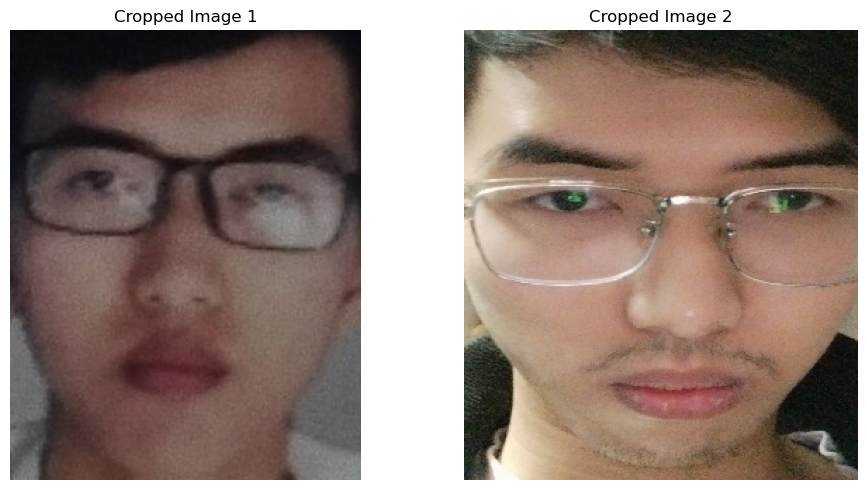

[2024-12-31 21:27:31,419] [    INFO] _internal.py:97 - 127.0.0.1 - - [31/Dec/2024 21:27:31] "POST /compare HTTP/1.1" 200 -


1/1 [==============================] - 0s 43ms/step
[2024/12/31 21:31:37] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.09068155288696289
[2024/12/31 21:31:37] ppocr DEBUG: cls num  : 26, elapsed : 0.0754537582397461
[2024/12/31 21:31:37] ppocr DEBUG: rec_res num  : 26, elapsed : 0.34444451332092285


[2024-12-31 21:31:37,843] [    INFO] _internal.py:97 - 127.0.0.1 - - [31/Dec/2024 21:31:37] "POST /getMSSV HTTP/1.1" 200 -


student_id_1MSSV not found
1/1 [==============================] - 0s 16ms/step
[2024/12/31 21:33:23] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.10726261138916016
[2024/12/31 21:33:23] ppocr DEBUG: cls num  : 27, elapsed : 0.0880882740020752
[2024/12/31 21:33:23] ppocr DEBUG: rec_res num  : 27, elapsed : 0.3362996578216553


[2024-12-31 21:33:23,498] [    INFO] _internal.py:97 - 127.0.0.1 - - [31/Dec/2024 21:33:23] "POST /getMSSV HTTP/1.1" 200 -


student_id_1MSSV not found


In [ ]:
if __name__ == '__main__':
    # Expose the Flask app via ngrok
    public_url = ngrok.connect(5000)
    print(f'Flask app running at {public_url}')

    # Run the Flask app
    app.run(port=5000)